<a href="https://colab.research.google.com/github/Lemon-Farm/2024S-Ajou-ML-/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [305]:
import os
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [306]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import seaborn as sns

In [307]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# pytorch 기초

pytorch의 장점은 backword를 자체적으로 수행할 수 있다는 것입니다.

아래의 코드는 2차원 데이터로 2차원의 weight와 1개의 bias 계산하는 예제입니다.

- (requires_grad=True) 가 설정된 tensor들은 자동으로 gradiant를 계산하고 저장합니다.

- loss_function을 통해 구해진 값에 대하여 .backword()를 수행하면 gradiant를 계산하게 됩니다.


In [308]:
import torch

X = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

# Initialize weights and bias with requires_grad=True
w = torch.tensor([[0.0], [0.0]], dtype=torch.float32,requires_grad=True)
b = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)
def forward(X):
    return torch.matmul(X, w) + b

def loss(Y, Y_pred):
    return ((Y_pred - Y) ** 2).mean()

learning_rate = 0.01
n_iters = 100

for epoch in range(n_iters):
    Y_pred = forward(X)
    l = loss(Y, Y_pred)

    # gradiant 초기화
    w.grad = None
    b.grad = None

    # backward pass
    l.backward()

    # weights와 bias 업데이트
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {l.item()}')

print("Trained weights:", w)
print("Trained bias:", b)

Epoch 1, Loss: 30.0
Epoch 11, Loss: 0.20919689536094666
Epoch 21, Loss: 0.19499194622039795
Epoch 31, Loss: 0.182020902633667
Epoch 41, Loss: 0.16991257667541504
Epoch 51, Loss: 0.15860998630523682
Epoch 61, Loss: 0.14805902540683746
Epoch 71, Loss: 0.13821005821228027
Epoch 81, Loss: 0.1290162056684494
Epoch 91, Loss: 0.12043382972478867
Trained weights: tensor([[0.8717],
        [0.8450]], requires_grad=True)
Trained bias: tensor([-0.0267], requires_grad=True)


아래의 예시는 위와 동일한 코드이지만, 편하게 사용할 수 있는 함수들입니다.

- 각 대응되는 부분들을 확인해보세요

In [309]:
import torch
import torch.nn as nn
import torch.optim as optim

In [310]:
# Define the data
X = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

initial_weight = torch.tensor([[0.0, 0.0]], dtype=torch.float32)
initial_bias = torch.tensor([0.0], dtype=torch.float32)


LinearModel = nn.Linear(in_features=2, out_features=1, bias=True)  # linear layer
LinearModel.weight.data = initial_weight.clone() #동일한 결과를 위해 동일하게 초기화
LinearModel.bias.data = initial_bias.clone() #동일한 결과를 위해 동일하게 초기화


criterion = nn.MSELoss() # loss fucntion 정의


optimizer = optim.SGD(LinearModel.parameters(), lr=0.01) # optimizer 정의

# Training loop
n_iters = 100
for epoch in range(n_iters):

    Y_pred = LinearModel(X)


    loss = criterion(Y_pred, Y)

    optimizer.zero_grad() # gradiant 초기화
    loss.backward() # backword process
    optimizer.step() # weight (&bias) update

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


trained_weight, trained_bias = LinearModel.weight.data, LinearModel.bias.data
print("Trained weights:", trained_weight)
print("Trained bias:", trained_bias)


Epoch 1, Loss: 30.0
Epoch 11, Loss: 0.20919689536094666
Epoch 21, Loss: 0.19499194622039795
Epoch 31, Loss: 0.18202082812786102
Epoch 41, Loss: 0.16991257667541504
Epoch 51, Loss: 0.15860998630523682
Epoch 61, Loss: 0.1480589509010315
Epoch 71, Loss: 0.13821005821228027
Epoch 81, Loss: 0.12901611626148224
Epoch 91, Loss: 0.12043388187885284
Trained weights: tensor([[0.8717, 0.8450]])
Trained bias: tensor([-0.0267])


#### GPU 사용

- 런타임 > 런타임 유형변경 > GPU 선택
- .to() method를 사용하여 GPU로 모델과 데이터를 올릴 수 있음
- .cuda() 를 사용하는 것도 가능


In [311]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LinearModel.to(device) # GPU로 올리기
print(LinearModel)

Linear(in_features=2, out_features=1, bias=True)


In [312]:
X = X.to(device) # data도 GPU로 올려야 연산 가능함

In [313]:
LinearModel(X)

tensor([[2.5349],
        [4.2516],
        [5.9683],
        [7.6850]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [314]:
LinearModel.cpu() # 다시 CPU로
X.cpu()

tensor([[1., 2.],
        [2., 3.],
        [3., 4.],
        [4., 5.]])

# 문제 1


- MNIST Dataset을 활용하여 손글씨 이미지(숫자)를 예측하는 모델을 만드세요.
- 해당 데이터는 0~9까지의 숫자를 가지고 있습니다.

In [315]:
# Load training data
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import random_split

MNIST 데이터를 데이터 로더에 넣어서 사용하면 미니 배치 단위로 꺼내 쓸 수 있습니다.

In [316]:
training_data = datasets.MNIST(
    root="data",
    train=True, # training data
    download=True,
    transform=v2.ToTensor() # 이미지를 tensor로 변형
)

val_size = 5000
train_size = len(training_data) - val_size
training_data, val_data = random_split(training_data, [train_size, val_size])

# Load test data
test_data = datasets.MNIST(
    root="data",
    train=False, # test data
    download=True,
    transform=v2.ToTensor() # 이미지를 tensor로 변형
)

# data loader
# train, test 각각의 data loader 생성
smaple_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [317]:
# train feature와 label을 train_loader로부터 가져오기
sample_features, sample_labels = next(iter(smaple_loader))
print(f"Feature batch shape: {sample_features.size()}")
print(f"Labels batch shape: {sample_labels.size()}")

Feature batch shape: torch.Size([1, 1, 28, 28])
Labels batch shape: torch.Size([1])


#### 이미지로 확인

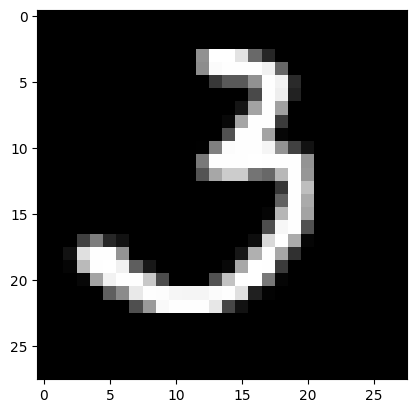

Label: 3


In [318]:
img = sample_features[0].squeeze()
label = sample_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 문제 1-1

MNIST 데이터셋을 아래의 조건에 따라 학습시키세요.

Fully connected layer (multi layer perceptron)로 NeuralNetwork를 아래의 조건에 맞게 완성하세요.

 - NeuralNetwork 모델 구축
    - 3개의 linear layer와 2개의 ReLU layer를 사용하세요.
    - nn.Linear, nn.ReLU
    - 각 layer의 hidden dimension size는 자유롭게 설정합니다.

In [319]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten() # 28x28 이미지를 784 픽셀 값의 배열로 변경
        self.linear_relu_stack = nn.Sequential(
            # 3개의 linear layer와 2개의 ReLU layer를 구성하세요
        #===================================================#
            nn.Linear(784, 384), # 784 input을 384 output으로 선형 변환
            nn.ReLU(), # activation function으로 ReLU 사용
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        #===================================================#
        )

    def forward(self, x):
        # forward 함수 구현
        #===================================================#
        x = self.flatten(x) # x를 벡터화
        logits = self.linear_relu_stack(x)
        #===================================================#
        return logits # forward 결과 저장

## 문제 1-2

위에서 만든 NeuralNetwork 모델을 학습시키세요.
train과 test함수를 만들세요.

- CrossEntropy 사용 (nn.CrossEntropyLoss)
- Epoch : 10, batch size : 32
- validation 정확도 90% 이상

In [320]:
# hyperparameter 설정
import torch.optim as optim
FcModel = NeuralNetwork()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(FcModel.parameters(), lr=0.001, momentum=0.9) # optimizer

EPOCHS = 10 # the number of epochs
n_batch = 32 # the number of batches

# data loader의 batch size을 16로 변경
train_loader = torch.utils.data.DataLoader(training_data, batch_size=n_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_batch, shuffle=True)

In [321]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler=None):
    size = 0
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        #===================================================#
        # GPU로 데이터 이동
        data_, target_ = data_.to(device), target_.to(device)

        # gradient 초기화 및 예측 계산
        optimizer.zero_grad()
        logits = model(data_)

        # loss 계산 (BCELoss를 사용할 때는 구조가 [batch size, 1]이라 통일시켜야 함)
        loss = loss_fn(logits.squeeze(), target_.float()) if isinstance(loss_fn, (nn.BCELoss)) else loss_fn(logits, target_)
        loss.backward()  # 그레디언트 계산(역전파)
        optimizer.step()  # 가중치 업데이트

        # 예측을 통해 loss, correct 계산 (BCELoss를 사용할 때는 sigmoid를 거친 값이 오므로 아래와 같이 구함)
        predict = (logits.squeeze() > 0.5).float() if isinstance(loss_fn, (nn.BCELoss)) else torch.argmax(logits, dim=1)
        size += target_.size(0) # 데이터 수만큼 더함
        epoch_correct += (predict == target_).sum().item()  # 맞춘 수만큼 더함
        epoch_loss += loss.item()  # loss 더하기
        #===================================================#

    if lr_scheduler != None:
        lr_scheduler.step()

    return epoch_correct/size , epoch_loss / num_batches

In [322]:
def test(dataloader , model , loss_fn):
    size = 0
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            # GPU로 데이터 이동
            data_, target_ = data_.to(device), target_.to(device)

            # 예측 계산
            logits = model(data_)

            # loss 계산 (BCELoss를 사용할 때는 구조가 [batch size, 1]이라 통일시켜야 함)
            loss = loss_fn(logits.squeeze(), target_.float()) if isinstance(loss_fn, (nn.BCELoss)) else loss_fn(logits, target_)

            # 예측을 통해 loss, correct 계산 (BCELoss를 사용할 때는 sigmoid를 거친 값이 오므로 아래와 같이 구함)
            predict = (logits.squeeze() > 0.5).float() if isinstance(loss_fn, (nn.BCELoss)) else torch.argmax(logits, dim=1)
            size += target_.size(0) # 데이터 수만큼 더함
            epoch_correct += (predict == target_).sum().item()  # 맞춘 수만큼 더함
            epoch_loss += loss.item()  # loss 더하기
            #========================================#

    return epoch_correct/size  , epoch_loss / num_baches

In [323]:
FcModel.cuda()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=384, bias=True)
    (1): ReLU()
    (2): Linear(in_features=384, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [324]:
best_loss = np.inf
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader, FcModel, criterion, optimizer)

    val_acc , val_loss = test(val_loader , FcModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(FcModel.state_dict() , "./NN_best.pth")


 10%|█         | 1/10 [00:10<01:36, 10.69s/it]

epoch:0     train_loss = 1.2011 , train_acc:0.7086     val_loss = 0.4761 , val_acc:0.8666     learning rate: 0.001


 20%|██        | 2/10 [00:21<01:24, 10.61s/it]

epoch:1     train_loss = 0.3817 , train_acc:0.8920     val_loss = 0.3603 , val_acc:0.8938     learning rate: 0.001


 30%|███       | 3/10 [00:31<01:13, 10.54s/it]

epoch:2     train_loss = 0.3108 , train_acc:0.9102     val_loss = 0.3132 , val_acc:0.9094     learning rate: 0.001


 40%|████      | 4/10 [00:42<01:03, 10.53s/it]

epoch:3     train_loss = 0.2708 , train_acc:0.9214     val_loss = 0.2860 , val_acc:0.9190     learning rate: 0.001


 50%|█████     | 5/10 [00:52<00:52, 10.48s/it]

epoch:4     train_loss = 0.2403 , train_acc:0.9310     val_loss = 0.2552 , val_acc:0.9264     learning rate: 0.001


 60%|██████    | 6/10 [01:03<00:41, 10.47s/it]

epoch:5     train_loss = 0.2141 , train_acc:0.9379     val_loss = 0.2267 , val_acc:0.9366     learning rate: 0.001


 70%|███████   | 7/10 [01:13<00:31, 10.47s/it]

epoch:6     train_loss = 0.1920 , train_acc:0.9449     val_loss = 0.2123 , val_acc:0.9408     learning rate: 0.001


 80%|████████  | 8/10 [01:23<00:20, 10.46s/it]

epoch:7     train_loss = 0.1733 , train_acc:0.9500     val_loss = 0.1926 , val_acc:0.9442     learning rate: 0.001


 90%|█████████ | 9/10 [01:34<00:10, 10.46s/it]

epoch:8     train_loss = 0.1574 , train_acc:0.9542     val_loss = 0.1816 , val_acc:0.9500     learning rate: 0.001


100%|██████████| 10/10 [01:44<00:00, 10.49s/it]

epoch:9     train_loss = 0.1428 , train_acc:0.9591     val_loss = 0.1699 , val_acc:0.9522     learning rate: 0.001


# 문제 1-3 : CNN

- CNN 모델을 아래의 조건과 같이 구축하여 학습하시오.
- validation 정확도 90% 이상

아래의 조건을 만족하는 CNN model을 만드시오.


 - CNN layer 1 - filter 수 32, filter size : 3,
 - Max pooling : 2 x 2
 - CNN layer 2 - filter 수 64, filter size : 3,
 - Max pooling : 2 x 2
 - CNN layer 3 - filter 수 128, filter size : 3,
 - Max pooling : 2 x 2
 - Fc layer 1 : last Cnn feature size (flatten) -> 128
 - ReLU ()
 - Fc layer 2 : 128 -> 64
 - ReLU ()
 - Fc layer 3 : 64 -> 10

In [325]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        #===============================================#
        # 조건에 부합하는 Layer 정의
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 32, 3) # (1, 28, 28) -> (32, 26, 26) -> (32, 13, 13)
        self.conv2 = nn.Conv2d(32, 64, 3) # (32, 13, 13) -> (64, 11, 11) -> (64, 5, 5)
        self.conv3 = nn.Conv2d(64, 128, 3) # (64, 5, 5) -> (128, 3, 3) ->(128, 1, 1)
        self.fc1 = nn.Linear(128, 128) # flattened input size는 위에서 구했듯이 128
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.pool = nn.MaxPool2d(2)
        #===============================================#


    def forward(self, x):

        #===============================================#
        # convolution layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # 평탄화
        x = self.flatten(x)

        # Fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #===============================================#

        return x

In [326]:
# hyperparameter 설정
import torch.optim as optim
SimModel = SimpleCNN()
SimModel.to(device)
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(SimModel.parameters(), lr=0.001, momentum=0.9) # optimizer

EPOCHS = 10 # the number of epochs
n_batch = 32 # the number of batches


train_loader = torch.utils.data.DataLoader(training_data, batch_size=n_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_batch, shuffle=True)

In [327]:
best_loss = np.inf
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   SimModel ,
                                   criterion ,
                                   optimizer )

    val_acc , val_loss = test(val_loader , SimModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(FcModel.state_dict() , "./Simple_CNN_best.pth")


 10%|█         | 1/10 [00:12<01:51, 12.35s/it]

epoch:0     train_loss = 2.2909 , train_acc:0.1523     val_loss = 2.2532 , val_acc:0.3612     learning rate: 0.001


 20%|██        | 2/10 [00:24<01:39, 12.38s/it]

epoch:1     train_loss = 1.0476 , train_acc:0.6826     val_loss = 0.4039 , val_acc:0.8686     learning rate: 0.001


 30%|███       | 3/10 [00:37<01:26, 12.42s/it]

epoch:2     train_loss = 0.2606 , train_acc:0.9183     val_loss = 0.2215 , val_acc:0.9328     learning rate: 0.001


 40%|████      | 4/10 [00:49<01:14, 12.39s/it]

epoch:3     train_loss = 0.1750 , train_acc:0.9458     val_loss = 0.1727 , val_acc:0.9506     learning rate: 0.001


 50%|█████     | 5/10 [01:01<01:02, 12.40s/it]

epoch:4     train_loss = 0.1371 , train_acc:0.9575     val_loss = 0.1416 , val_acc:0.9592     learning rate: 0.001


 60%|██████    | 6/10 [01:14<00:49, 12.40s/it]

epoch:5     train_loss = 0.1128 , train_acc:0.9650     val_loss = 0.1131 , val_acc:0.9678     learning rate: 0.001


 70%|███████   | 7/10 [01:26<00:37, 12.36s/it]

epoch:6     train_loss = 0.0974 , train_acc:0.9693     val_loss = 0.0998 , val_acc:0.9714     learning rate: 0.001


 80%|████████  | 8/10 [01:38<00:24, 12.35s/it]

epoch:7     train_loss = 0.0874 , train_acc:0.9735     val_loss = 0.1055 , val_acc:0.9696     learning rate: 0.001


 90%|█████████ | 9/10 [01:51<00:12, 12.34s/it]

epoch:8     train_loss = 0.0776 , train_acc:0.9764     val_loss = 0.0931 , val_acc:0.9742     learning rate: 0.001


100%|██████████| 10/10 [02:03<00:00, 12.37s/it]

epoch:9     train_loss = 0.0703 , train_acc:0.9785     val_loss = 0.0872 , val_acc:0.9730     learning rate: 0.001


# Smoke image dataset


- 본 데이터셋은 흡연자의 모습과 비흡자의 모습이 담긴 이미지 파일입니다.
- 이미지 파일을 python으로 가져오기 위해서 다음 과정을 수행합니다.



1.   이미지가 있는 file path를 pandas DataFrame에 label과 함께 저장
2.   데이터 로드를 효율적으로 하기 위해서, 학습 배치마다 해당 path의 이미지를 불러옴



In [12]:
from PIL import Image
from glob import glob

In [168]:
data_path = "/content/drive/MyDrive/자료/smoke"

In [169]:
import pandas as pd
import os
from glob import glob

def create_dataframe(data_path, label_list, data_type):
    df = pd.DataFrame({"path": [], "label": [], "class_id": []})
    img_list = glob(os.path.join(data_path, '*.jpg'))

    for img in img_list:
        file_name = os.path.splitext(img)[0].split("/")[-1]
        if file_name[0:len(label_list[0])] == label_list[0]:
            new_data =pd.DataFrame({"path":img,"label":label_list[0], "class_id":0}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)
        elif file_name[0:len(label_list[1])] == label_list[1]:
            new_data =pd.DataFrame({"path":img,"label":label_list[1], "class_id":1}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)

    df[["path"]] = df[["path"]].astype(str)
    df[["label"]] = df[["label"]].astype(str)
    df[["class_id"]] = df[["class_id"]].astype(int)

    return df

In [173]:
# Example usage:
train_path = data_path + '/Training/Training/'
valid_path = data_path + '/Validation/Validation/'
test_path = data_path + '/Testing/Testing/'
label_list = ['notsmoking', 'smoking']

train_df = create_dataframe(train_path, label_list, 'training')
val_df = create_dataframe(valid_path, label_list, 'validation')
test_df = create_dataframe(test_path, label_list, 'test')

In [174]:
print(f"train_data: {len(train_df)}")
print(f"val_data:{len(val_df)}")
print(f"test_data:{len(test_df)}")

train_data: 716
val_data:180
test_data:224


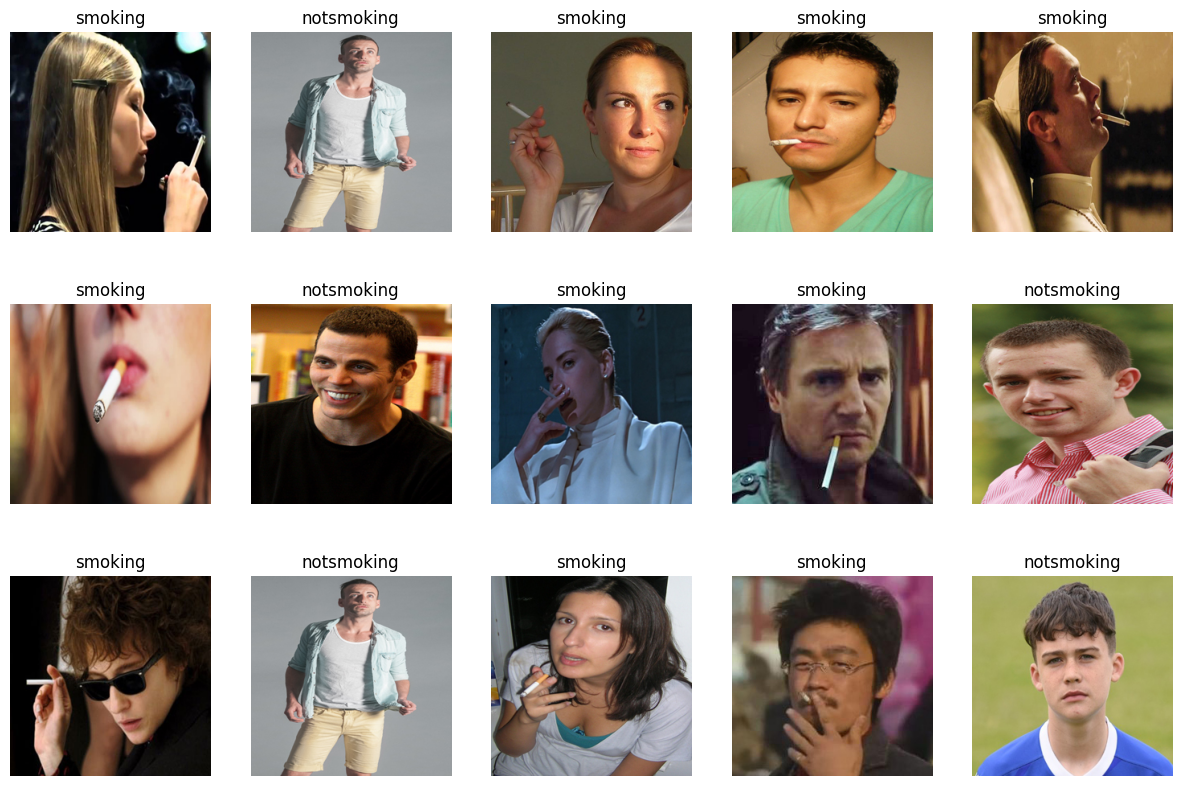

In [175]:
show_imgs = 15
idx = np.random.randint(0,len(val_df) , size = show_imgs)
fig , axes = plt.subplots(show_imgs // 5 , 5 , figsize = (15 , 10))
axes = axes.flatten()
for i , ax in enumerate(axes):
    full_path = val_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(val_df.loc[idx[i]]['label'])
    ax.set_axis_off()

## Dataset & Dataloader

Pytorch의 Dataset & Dataloader은, 데이터를 다루고 모델을 훈련 및 시험하기 위하여 가장 주의를 기울여야 될 부분 중의 하나입니다.

Dataset은 전체 데이터에서 특정 데이터를 꺼내오는 역할 및 전처리나 augmentation, 추가적인 function 처리를 효율적으로 할 수 있도록 합니다.
Dataloader의 경우, Dataset을 Minibatch 형태로 만들어 주며, Batch size나, Shuffle 여부에 대한 것들을 설정할 수 있습니다.

자세한 사항은 아래의 링크를 확인해보시기 바랍니다.

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [264]:
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [265]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self , dataframe , transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self ,index):
        img_path = self.df.iloc[index]['path']
        img = Image.open(img_path).convert("RGB")
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img , class_id

In [266]:
SimpleTransforms = v2.Compose([
    v2.Resize((224,224)), # image 크기 맞추기
    v2.PILToTensor(), # torch.tensor로 변환
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]) # dtype 변환

In [267]:
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
example_dataset = BaseDataset(train_df , SimpleTransforms) # train_transforms
example_loader = DataLoader(example_dataset , batch_size=BATCH_SIZE , shuffle = True)

In [22]:
img, class_id = next(iter(example_dataset))

In [23]:
img.shape # (batch, channel, W, H)

torch.Size([3, 224, 224])

In [24]:
img, class_id = next(iter(example_loader))

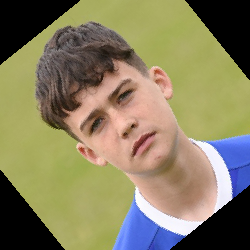

In [328]:
# augmentation 참고
# https://pytorch.org/vision/main/transforms.html

rotation_transform = v2.RandomRotation(degrees=90) # compose에 추가 가능
image = Image.open(full_path)
rotated_image = rotation_transform(image)
rotated_image


# 문제 2

 1-1의 모델을 **layer를 추가하지 않고**, 아래의 조건을 토대로 성능을
 향상시켜보세요.


 - batch norm, dropout 둘 다 적용
 - data augmentation 기법 1가지 이상 추가
 - layer 자체를 추가하는 것 이외의 다른 방법들 추가 적용 가능
    - kernel size 등등
    - max pooling은 layer로 취급하지 않음
    - 이외 추가적인 hyperparameter 변경 가능
    - feature size 당연히, 수정 가능
 - **test acc (75%) 이상 달성**

In [329]:
CustomTransforms = v2.Compose([
    #===============================#
    v2.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 랜덤으로 크롭하고 리사이즈
    v2.RandomHorizontalFlip(p=0.5),  # 50% 확률로 이미지를 좌우반전
    v2.RandomRotation(15),  # 랜덤으로 15도 회전
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 밝기, 대비, 채도, 색조 랜덤 조정
    v2.RandomGrayscale(p=0.1),  # 10% 확률로 흑백 변환
    v2.Resize((224, 224)),  # image 크기 맞추기
    v2.ToTensor(),  # torch.tensor로 변환
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #===============================#
    ]) # dtype 변환

In [330]:
#get dataloader

train_dataset = BaseDataset(train_df , CustomTransforms) # train_transforms
val_dataset = BaseDataset(val_df , CustomTransforms)
test_dataset = BaseDataset(test_df , CustomTransforms)
train_loader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset , batch_size=BATCH_SIZE)

In [294]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()



        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # (3, 224, 224) -> (32, 224, 224) -> (32, 112, 112)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (32, 112, 112) -> (64, 112, 112) -> (64, 56, 56)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)# (64, 56, 56) -> (128, 56, 56) -> (128, 28, 28)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)


        #===============================================#
        # Batch Normalization 정의
        self.BNorm1 = nn.BatchNorm2d(32)
        self.BNorm2 = nn.BatchNorm2d(64)
        self.BNorm3 = nn.BatchNorm2d(128)

        self.flatten = nn.Flatten()

        # Dropout 정의
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.3)
        #===============================================#

    def forward(self, x):

        #===============================================#
        # Convolution Layer 적용
        x = self.pool(F.relu(self.BNorm1(self.conv1(x))))
        x = self.pool(F.relu(self.BNorm2(self.conv2(x))))
        x = self.pool(F.relu(self.BNorm3(self.conv3(x))))

        # FC Layer 적용
        x = self.flatten(x)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = F.sigmoid(self.fc3(x)) # BCEloss에는 마지막으로 sigmoid를 적용한 값이 들어가야 된다고 함
        #===============================================#

        return x


In [331]:
ImpModel = ImprovedCNN()
ImpModel.cuda()

ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (BNorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout1): Dropout(p=0.4, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
)

In [335]:
EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()

# hyperparameter 추가 및 변경 가능 설정해보세요
# optimizer, lr_scheduler 변경 가능
#==============================#
criterion = nn.BCELoss().to(device)
optimizer = optim.AdamW(ImpModel.parameters(), lr=1e-4, weight_decay=1e-4) # AdamW 사용
Cosine_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50) # Cosine Annealing LR Scheduler 사용 / T_max는 EPOCH 수의 절반으로 지정함
#==============================#

In [336]:
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   ImpModel ,
                                   criterion ,
                                   optimizer ,
                                   Cosine_lr_scheduler)

    val_acc , val_loss = test(val_loader , ImpModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(ImpModel.state_dict() , "checkpoints/Improved_CNN_best.pth")

# early_stop 제거

  1%|          | 1/100 [00:11<18:43, 11.34s/it]

epoch:0     train_loss = 0.6474 , train_acc:0.6564     val_loss = 0.5677 , val_acc:0.7056     learning rate: 9.990133642141359e-05


  2%|▏         | 2/100 [00:22<18:23, 11.26s/it]

epoch:1     train_loss = 0.5964 , train_acc:0.7179     val_loss = 0.5822 , val_acc:0.7278     learning rate: 9.96057350657239e-05


  3%|▎         | 3/100 [00:33<18:11, 11.25s/it]

epoch:2     train_loss = 0.5969 , train_acc:0.7011     val_loss = 0.5603 , val_acc:0.7167     learning rate: 9.911436253643444e-05


  4%|▍         | 4/100 [00:45<17:59, 11.25s/it]

epoch:3     train_loss = 0.6073 , train_acc:0.6676     val_loss = 0.5600 , val_acc:0.7389     learning rate: 9.842915805643155e-05


  5%|▌         | 5/100 [00:56<17:47, 11.24s/it]

epoch:4     train_loss = 0.5822 , train_acc:0.7151     val_loss = 0.5495 , val_acc:0.7722     learning rate: 9.755282581475769e-05


  6%|▌         | 6/100 [01:07<17:34, 11.22s/it]

epoch:5     train_loss = 0.5760 , train_acc:0.7137     val_loss = 0.5560 , val_acc:0.7167     learning rate: 9.648882429441257e-05


  7%|▋         | 7/100 [01:18<17:20, 11.19s/it]

epoch:6     train_loss = 0.5698 , train_acc:0.7095     val_loss = 0.5971 , val_acc:0.7167     learning rate: 9.524135262330098e-05


  8%|▊         | 8/100 [01:29<17:12, 11.22s/it]

epoch:7     train_loss = 0.5475 , train_acc:0.7458     val_loss = 0.5726 , val_acc:0.7056     learning rate: 9.381533400219317e-05


  9%|▉         | 9/100 [01:41<17:02, 11.24s/it]

epoch:8     train_loss = 0.5733 , train_acc:0.7095     val_loss = 0.5628 , val_acc:0.7000     learning rate: 9.221639627510075e-05


 10%|█         | 10/100 [01:52<16:49, 11.22s/it]

epoch:9     train_loss = 0.5407 , train_acc:0.7291     val_loss = 0.5438 , val_acc:0.7444     learning rate: 9.045084971874735e-05


 11%|█         | 11/100 [02:03<16:38, 11.22s/it]

epoch:10     train_loss = 0.5473 , train_acc:0.7402     val_loss = 0.5648 , val_acc:0.7111     learning rate: 8.852566213878945e-05


 12%|█▏        | 12/100 [02:14<16:29, 11.24s/it]

epoch:11     train_loss = 0.5383 , train_acc:0.7318     val_loss = 0.5522 , val_acc:0.7444     learning rate: 8.644843137107056e-05


 13%|█▎        | 13/100 [02:26<16:16, 11.23s/it]

epoch:12     train_loss = 0.5492 , train_acc:0.7318     val_loss = 0.5642 , val_acc:0.7389     learning rate: 8.422735529643442e-05


 14%|█▍        | 14/100 [02:37<16:05, 11.23s/it]

epoch:13     train_loss = 0.5429 , train_acc:0.7263     val_loss = 0.5177 , val_acc:0.7611     learning rate: 8.187119948743447e-05


 15%|█▌        | 15/100 [02:48<15:55, 11.24s/it]

epoch:14     train_loss = 0.5456 , train_acc:0.7291     val_loss = 0.5372 , val_acc:0.7556     learning rate: 7.938926261462366e-05


 16%|█▌        | 16/100 [03:00<15:50, 11.32s/it]

epoch:15     train_loss = 0.5257 , train_acc:0.7360     val_loss = 0.5731 , val_acc:0.6778     learning rate: 7.679133974894982e-05


 17%|█▋        | 17/100 [03:11<15:37, 11.29s/it]

epoch:16     train_loss = 0.5412 , train_acc:0.7235     val_loss = 0.4774 , val_acc:0.7722     learning rate: 7.408768370508575e-05


 18%|█▊        | 18/100 [03:22<15:23, 11.27s/it]

epoch:17     train_loss = 0.5499 , train_acc:0.7179     val_loss = 0.5159 , val_acc:0.7722     learning rate: 7.128896457825361e-05


 19%|█▉        | 19/100 [03:33<15:12, 11.27s/it]

epoch:18     train_loss = 0.5430 , train_acc:0.7374     val_loss = 0.5253 , val_acc:0.7389     learning rate: 6.840622763423389e-05


 20%|██        | 20/100 [03:44<14:57, 11.22s/it]

epoch:19     train_loss = 0.5334 , train_acc:0.7444     val_loss = 0.5191 , val_acc:0.7222     learning rate: 6.545084971874736e-05


 21%|██        | 21/100 [03:56<14:46, 11.22s/it]

epoch:20     train_loss = 0.5089 , train_acc:0.7486     val_loss = 0.5102 , val_acc:0.7444     learning rate: 6.243449435824272e-05


 22%|██▏       | 22/100 [04:07<14:35, 11.22s/it]

epoch:21     train_loss = 0.5133 , train_acc:0.7151     val_loss = 0.5078 , val_acc:0.7611     learning rate: 5.9369065729286224e-05


 23%|██▎       | 23/100 [04:18<14:22, 11.21s/it]

epoch:22     train_loss = 0.5131 , train_acc:0.7723     val_loss = 0.5151 , val_acc:0.7500     learning rate: 5.626666167821521e-05


 24%|██▍       | 24/100 [04:29<14:10, 11.20s/it]

epoch:23     train_loss = 0.5202 , train_acc:0.7458     val_loss = 0.5230 , val_acc:0.7278     learning rate: 5.3139525976465657e-05


 25%|██▌       | 25/100 [04:40<14:00, 11.21s/it]

epoch:24     train_loss = 0.4888 , train_acc:0.7472     val_loss = 0.5457 , val_acc:0.7500     learning rate: 4.999999999999998e-05


 26%|██▌       | 26/100 [04:52<13:48, 11.20s/it]

epoch:25     train_loss = 0.5091 , train_acc:0.7332     val_loss = 0.5151 , val_acc:0.7722     learning rate: 4.6860474023534314e-05


 27%|██▋       | 27/100 [05:03<13:43, 11.28s/it]

epoch:26     train_loss = 0.5081 , train_acc:0.7654     val_loss = 0.5311 , val_acc:0.7222     learning rate: 4.3733338321784775e-05


 28%|██▊       | 28/100 [05:14<13:33, 11.30s/it]

epoch:27     train_loss = 0.4943 , train_acc:0.7751     val_loss = 0.5176 , val_acc:0.7111     learning rate: 4.063093427071375e-05


 29%|██▉       | 29/100 [05:26<13:19, 11.26s/it]

epoch:28     train_loss = 0.5004 , train_acc:0.7444     val_loss = 0.5331 , val_acc:0.7333     learning rate: 3.756550564175724e-05


 30%|███       | 30/100 [05:37<13:07, 11.25s/it]

epoch:29     train_loss = 0.4925 , train_acc:0.7542     val_loss = 0.5063 , val_acc:0.7778     learning rate: 3.454915028125263e-05


 31%|███       | 31/100 [05:48<12:57, 11.26s/it]

epoch:30     train_loss = 0.5052 , train_acc:0.7486     val_loss = 0.5180 , val_acc:0.7333     learning rate: 3.1593772365766105e-05


 32%|███▏      | 32/100 [05:59<12:46, 11.28s/it]

epoch:31     train_loss = 0.5002 , train_acc:0.7556     val_loss = 0.4944 , val_acc:0.7333     learning rate: 2.8711035421746357e-05


 33%|███▎      | 33/100 [06:11<12:34, 11.26s/it]

epoch:32     train_loss = 0.4857 , train_acc:0.7737     val_loss = 0.4924 , val_acc:0.7611     learning rate: 2.591231629491422e-05


 34%|███▍      | 34/100 [06:22<12:21, 11.24s/it]

epoch:33     train_loss = 0.4705 , train_acc:0.7682     val_loss = 0.5189 , val_acc:0.7667     learning rate: 2.3208660251050148e-05


 35%|███▌      | 35/100 [06:33<12:10, 11.24s/it]

epoch:34     train_loss = 0.4926 , train_acc:0.7668     val_loss = 0.5071 , val_acc:0.7500     learning rate: 2.061073738537634e-05


 36%|███▌      | 36/100 [06:44<11:58, 11.22s/it]

epoch:35     train_loss = 0.4791 , train_acc:0.7709     val_loss = 0.5236 , val_acc:0.7500     learning rate: 1.8128800512565503e-05


 37%|███▋      | 37/100 [06:55<11:48, 11.25s/it]

epoch:36     train_loss = 0.4803 , train_acc:0.7696     val_loss = 0.5053 , val_acc:0.7611     learning rate: 1.5772644703565555e-05


 38%|███▊      | 38/100 [07:07<11:38, 11.26s/it]

epoch:37     train_loss = 0.4834 , train_acc:0.7486     val_loss = 0.5105 , val_acc:0.7556     learning rate: 1.3551568628929426e-05


 39%|███▉      | 39/100 [07:18<11:28, 11.29s/it]

epoch:38     train_loss = 0.4458 , train_acc:0.7793     val_loss = 0.5296 , val_acc:0.7389     learning rate: 1.1474337861210536e-05


 40%|████      | 40/100 [07:29<11:16, 11.28s/it]

epoch:39     train_loss = 0.4900 , train_acc:0.7528     val_loss = 0.5185 , val_acc:0.7278     learning rate: 9.549150281252626e-06


 41%|████      | 41/100 [07:41<11:04, 11.26s/it]

epoch:40     train_loss = 0.4783 , train_acc:0.7570     val_loss = 0.5211 , val_acc:0.7389     learning rate: 7.783603724899252e-06


 42%|████▏     | 42/100 [07:52<10:51, 11.24s/it]

epoch:41     train_loss = 0.4873 , train_acc:0.7486     val_loss = 0.5168 , val_acc:0.7722     learning rate: 6.184665997806817e-06


 43%|████▎     | 43/100 [08:03<10:41, 11.26s/it]

epoch:42     train_loss = 0.4671 , train_acc:0.7570     val_loss = 0.4692 , val_acc:0.7889     learning rate: 4.75864737669903e-06


 44%|████▍     | 44/100 [08:14<10:29, 11.24s/it]

epoch:43     train_loss = 0.4841 , train_acc:0.7737     val_loss = 0.5005 , val_acc:0.7611     learning rate: 3.5111757055874303e-06


 45%|████▌     | 45/100 [08:26<10:19, 11.26s/it]

epoch:44     train_loss = 0.4681 , train_acc:0.7709     val_loss = 0.5307 , val_acc:0.7333     learning rate: 2.4471741852423216e-06


 46%|████▌     | 46/100 [08:37<10:07, 11.25s/it]

epoch:45     train_loss = 0.4847 , train_acc:0.7598     val_loss = 0.4767 , val_acc:0.7722     learning rate: 1.5708419435684504e-06


 47%|████▋     | 47/100 [08:48<09:57, 11.27s/it]

epoch:46     train_loss = 0.4717 , train_acc:0.7668     val_loss = 0.5148 , val_acc:0.7833     learning rate: 8.856374635655631e-07


 48%|████▊     | 48/100 [08:59<09:44, 11.24s/it]

epoch:47     train_loss = 0.4872 , train_acc:0.7709     val_loss = 0.5302 , val_acc:0.7222     learning rate: 3.942649342761114e-07


 49%|████▉     | 49/100 [09:10<09:31, 11.21s/it]

epoch:48     train_loss = 0.4635 , train_acc:0.7765     val_loss = 0.5110 , val_acc:0.7444     learning rate: 9.866357858642197e-08


 50%|█████     | 50/100 [09:22<09:22, 11.25s/it]

epoch:49     train_loss = 0.4759 , train_acc:0.7765     val_loss = 0.5105 , val_acc:0.7611     learning rate: 0.0


 51%|█████     | 51/100 [09:33<09:11, 11.25s/it]

epoch:50     train_loss = 0.4664 , train_acc:0.7835     val_loss = 0.4922 , val_acc:0.7333     learning rate: 9.866357858642205e-08


 52%|█████▏    | 52/100 [09:44<09:01, 11.28s/it]

epoch:51     train_loss = 0.4719 , train_acc:0.7528     val_loss = 0.5015 , val_acc:0.7611     learning rate: 3.942649342761062e-07


 53%|█████▎    | 53/100 [09:56<08:50, 11.28s/it]

epoch:52     train_loss = 0.4959 , train_acc:0.7626     val_loss = 0.5112 , val_acc:0.7444     learning rate: 8.856374635655695e-07


 54%|█████▍    | 54/100 [10:07<08:38, 11.28s/it]

epoch:53     train_loss = 0.4630 , train_acc:0.7765     val_loss = 0.4985 , val_acc:0.7333     learning rate: 1.5708419435684407e-06


 55%|█████▌    | 55/100 [10:18<08:26, 11.26s/it]

epoch:54     train_loss = 0.4577 , train_acc:0.7723     val_loss = 0.5048 , val_acc:0.7667     learning rate: 2.447174185242318e-06


 56%|█████▌    | 56/100 [10:29<08:15, 11.26s/it]

epoch:55     train_loss = 0.4595 , train_acc:0.7765     val_loss = 0.5260 , val_acc:0.7611     learning rate: 3.511175705587427e-06


 57%|█████▋    | 57/100 [10:41<08:04, 11.27s/it]

epoch:56     train_loss = 0.4770 , train_acc:0.7682     val_loss = 0.4981 , val_acc:0.7611     learning rate: 4.758647376699015e-06


 58%|█████▊    | 58/100 [10:52<07:52, 11.25s/it]

epoch:57     train_loss = 0.4502 , train_acc:0.7682     val_loss = 0.5151 , val_acc:0.7389     learning rate: 6.184665997806826e-06


 59%|█████▉    | 59/100 [11:03<07:41, 11.25s/it]

epoch:58     train_loss = 0.4627 , train_acc:0.7793     val_loss = 0.5196 , val_acc:0.7500     learning rate: 7.78360372489924e-06


 60%|██████    | 60/100 [11:14<07:30, 11.25s/it]

epoch:59     train_loss = 0.4645 , train_acc:0.7891     val_loss = 0.4949 , val_acc:0.7778     learning rate: 9.54915028125261e-06


 61%|██████    | 61/100 [11:26<07:18, 11.24s/it]

epoch:60     train_loss = 0.4703 , train_acc:0.7654     val_loss = 0.4936 , val_acc:0.7611     learning rate: 1.1474337861210536e-05


 62%|██████▏   | 62/100 [11:37<07:06, 11.21s/it]

epoch:61     train_loss = 0.4784 , train_acc:0.7556     val_loss = 0.5042 , val_acc:0.7778     learning rate: 1.3551568628929409e-05


 63%|██████▎   | 63/100 [11:48<06:54, 11.19s/it]

epoch:62     train_loss = 0.4769 , train_acc:0.7514     val_loss = 0.5230 , val_acc:0.7722     learning rate: 1.5772644703565565e-05


 64%|██████▍   | 64/100 [11:59<06:43, 11.20s/it]

epoch:63     train_loss = 0.4682 , train_acc:0.7682     val_loss = 0.5163 , val_acc:0.7667     learning rate: 1.8128800512565517e-05


 65%|██████▌   | 65/100 [12:10<06:31, 11.20s/it]

epoch:64     train_loss = 0.4880 , train_acc:0.7668     val_loss = 0.4832 , val_acc:0.7611     learning rate: 2.0610737385376332e-05


 66%|██████▌   | 66/100 [12:22<06:21, 11.21s/it]

epoch:65     train_loss = 0.4698 , train_acc:0.7751     val_loss = 0.5063 , val_acc:0.7722     learning rate: 2.320866025105018e-05


 67%|██████▋   | 67/100 [12:33<06:10, 11.24s/it]

epoch:66     train_loss = 0.4850 , train_acc:0.7709     val_loss = 0.5098 , val_acc:0.7722     learning rate: 2.5912316294914232e-05


 68%|██████▊   | 68/100 [12:44<05:58, 11.21s/it]

epoch:67     train_loss = 0.4722 , train_acc:0.7751     val_loss = 0.5257 , val_acc:0.7333     learning rate: 2.871103542174638e-05


 69%|██████▉   | 69/100 [12:55<05:47, 11.22s/it]

epoch:68     train_loss = 0.4747 , train_acc:0.7849     val_loss = 0.5000 , val_acc:0.7278     learning rate: 3.15937723657661e-05


 70%|███████   | 70/100 [13:07<05:36, 11.23s/it]

epoch:69     train_loss = 0.4691 , train_acc:0.7472     val_loss = 0.5003 , val_acc:0.7722     learning rate: 3.454915028125261e-05


 71%|███████   | 71/100 [13:18<05:25, 11.24s/it]

epoch:70     train_loss = 0.4705 , train_acc:0.7598     val_loss = 0.4846 , val_acc:0.7611     learning rate: 3.756550564175727e-05


 72%|███████▏  | 72/100 [13:29<05:13, 11.21s/it]

epoch:71     train_loss = 0.4691 , train_acc:0.7556     val_loss = 0.4833 , val_acc:0.7833     learning rate: 4.063093427071376e-05


 73%|███████▎  | 73/100 [13:40<05:03, 11.23s/it]

epoch:72     train_loss = 0.4441 , train_acc:0.7891     val_loss = 0.5094 , val_acc:0.7667     learning rate: 4.373333832178476e-05


 74%|███████▍  | 74/100 [13:51<04:52, 11.23s/it]

epoch:73     train_loss = 0.4599 , train_acc:0.7877     val_loss = 0.4649 , val_acc:0.7889     learning rate: 4.6860474023534335e-05


 75%|███████▌  | 75/100 [14:03<04:41, 11.26s/it]

epoch:74     train_loss = 0.4748 , train_acc:0.7682     val_loss = 0.4805 , val_acc:0.7722     learning rate: 4.999999999999999e-05


 76%|███████▌  | 76/100 [14:14<04:29, 11.24s/it]

epoch:75     train_loss = 0.4538 , train_acc:0.7612     val_loss = 0.5434 , val_acc:0.7833     learning rate: 5.3139525976465636e-05


 77%|███████▋  | 77/100 [14:25<04:17, 11.19s/it]

epoch:76     train_loss = 0.4612 , train_acc:0.7877     val_loss = 0.5221 , val_acc:0.7333     learning rate: 5.626666167821521e-05


 78%|███████▊  | 78/100 [14:36<04:06, 11.21s/it]

epoch:77     train_loss = 0.4810 , train_acc:0.7709     val_loss = 0.4879 , val_acc:0.7722     learning rate: 5.936906572928621e-05


 79%|███████▉  | 79/100 [14:48<03:56, 11.25s/it]

epoch:78     train_loss = 0.4789 , train_acc:0.7654     val_loss = 0.4801 , val_acc:0.7667     learning rate: 6.243449435824273e-05


 80%|████████  | 80/100 [14:59<03:45, 11.26s/it]

epoch:79     train_loss = 0.4394 , train_acc:0.7989     val_loss = 0.4828 , val_acc:0.7722     learning rate: 6.545084971874734e-05


 81%|████████  | 81/100 [15:10<03:33, 11.24s/it]

epoch:80     train_loss = 0.4615 , train_acc:0.7835     val_loss = 0.5088 , val_acc:0.7889     learning rate: 6.840622763423386e-05


 82%|████████▏ | 82/100 [15:22<03:23, 11.31s/it]

epoch:81     train_loss = 0.4695 , train_acc:0.7709     val_loss = 0.5260 , val_acc:0.7333     learning rate: 7.128896457825357e-05


 83%|████████▎ | 83/100 [15:33<03:12, 11.29s/it]

epoch:82     train_loss = 0.4780 , train_acc:0.7584     val_loss = 0.4954 , val_acc:0.7778     learning rate: 7.408768370508576e-05


 84%|████████▍ | 84/100 [15:44<03:00, 11.25s/it]

epoch:83     train_loss = 0.4526 , train_acc:0.7793     val_loss = 0.5061 , val_acc:0.8111     learning rate: 7.679133974894982e-05


 85%|████████▌ | 85/100 [15:55<02:48, 11.24s/it]

epoch:84     train_loss = 0.4557 , train_acc:0.7779     val_loss = 0.5662 , val_acc:0.7111     learning rate: 7.938926261462363e-05


 86%|████████▌ | 86/100 [16:07<02:37, 11.26s/it]

epoch:85     train_loss = 0.4753 , train_acc:0.7668     val_loss = 0.5066 , val_acc:0.7889     learning rate: 8.187119948743444e-05


 87%|████████▋ | 87/100 [16:18<02:28, 11.40s/it]

epoch:86     train_loss = 0.4447 , train_acc:0.7975     val_loss = 0.4635 , val_acc:0.7611     learning rate: 8.422735529643437e-05


 88%|████████▊ | 88/100 [16:30<02:16, 11.37s/it]

epoch:87     train_loss = 0.4646 , train_acc:0.7709     val_loss = 0.5193 , val_acc:0.7500     learning rate: 8.644843137107053e-05


 89%|████████▉ | 89/100 [16:41<02:04, 11.31s/it]

epoch:88     train_loss = 0.4716 , train_acc:0.7821     val_loss = 0.4984 , val_acc:0.7444     learning rate: 8.852566213878945e-05


 90%|█████████ | 90/100 [16:52<01:52, 11.27s/it]

epoch:89     train_loss = 0.4762 , train_acc:0.7626     val_loss = 0.5272 , val_acc:0.7389     learning rate: 9.045084971874734e-05


 91%|█████████ | 91/100 [17:03<01:41, 11.23s/it]

epoch:90     train_loss = 0.4614 , train_acc:0.7598     val_loss = 0.5293 , val_acc:0.7333     learning rate: 9.221639627510072e-05


 92%|█████████▏| 92/100 [17:14<01:29, 11.24s/it]

epoch:91     train_loss = 0.4719 , train_acc:0.7458     val_loss = 0.5318 , val_acc:0.7333     learning rate: 9.381533400219313e-05


 93%|█████████▎| 93/100 [17:26<01:18, 11.26s/it]

epoch:92     train_loss = 0.4399 , train_acc:0.7821     val_loss = 0.4887 , val_acc:0.7833     learning rate: 9.524135262330094e-05


 94%|█████████▍| 94/100 [17:37<01:07, 11.25s/it]

epoch:93     train_loss = 0.4554 , train_acc:0.7737     val_loss = 0.5161 , val_acc:0.7778     learning rate: 9.648882429441254e-05


 95%|█████████▌| 95/100 [17:48<00:56, 11.28s/it]

epoch:94     train_loss = 0.4411 , train_acc:0.7933     val_loss = 0.4871 , val_acc:0.7611     learning rate: 9.755282581475765e-05


 96%|█████████▌| 96/100 [17:59<00:45, 11.26s/it]

epoch:95     train_loss = 0.4421 , train_acc:0.7835     val_loss = 0.5158 , val_acc:0.6778     learning rate: 9.842915805643151e-05


 97%|█████████▋| 97/100 [18:11<00:33, 11.24s/it]

epoch:96     train_loss = 0.4633 , train_acc:0.7668     val_loss = 0.5152 , val_acc:0.7444     learning rate: 9.911436253643439e-05


 98%|█████████▊| 98/100 [18:22<00:22, 11.24s/it]

epoch:97     train_loss = 0.4766 , train_acc:0.7556     val_loss = 0.5485 , val_acc:0.7722     learning rate: 9.960573506572383e-05


 99%|█████████▉| 99/100 [18:33<00:11, 11.24s/it]

epoch:98     train_loss = 0.4770 , train_acc:0.7835     val_loss = 0.5292 , val_acc:0.7389     learning rate: 9.990133642141353e-05


100%|██████████| 100/100 [18:44<00:00, 11.25s/it]

epoch:99     train_loss = 0.4589 , train_acc:0.7570     val_loss = 0.5503 , val_acc:0.7056     learning rate: 9.999999999999996e-05


In [337]:
# test 성능 출력
test_acc , val_loss = test(test_loader , ImpModel , criterion)
print(test_acc)

0.75


# 문제 3: Pretrained model
사전 학습된 모델(Pretrained model)을 통해 위의 이미지 데이터를  흡연 여부를 판별고자 합니다.

이를 위해서 모델을 불러오고, 학습 및 검증하여 최종 성능을 평가하시오.

In [338]:
# pretrained 관련
import torch
import torchvision.transforms as v2
from torchvision import models

In [339]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 문제 3-1: Pretrained Model (backborn)모델 학습

아래의 `resnet18` 예제를 참고하여, `vgg16`의 pretrained model를 불러와 Smoke 탐지를 진행할 수 있도록 layer를 수정하시오.

- MyVGG16 Class를 완성하시오.
- Vgg16의 CNN layer들은 모두 frozen하시오.
- 추가적인 layer와 다양한 기법들을 추가해도 됩니다.
- **test acc (75%) 이상 달성**
- **(extra) test acc (80%) 이상 달성시 추가 점수(+1): freeze한 layer fine-tuning 가능**


- https://pytorch.org/vision/stable/models.html 참고

In [340]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [341]:
print(resnet18) # 각 레이어의 구성을 확인

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [342]:
Last_layer_hiddensize = resnet18.fc.in_features
resnet18.fc = nn.Linear(Last_layer_hiddensize, 1)

In [343]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

In [344]:
# nn.Linear(10,10).requires_grad = False # gradiant 끄기
# nn.Linear(10,10).requires_grad = True # gradiant 켜기
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [346]:
import torch.nn as nn
class MyVGG16(nn.Module):
    def __init__(self, pretrained_model):
        super(MyVGG16, self).__init__()
        self.backbone = pretrained_model

        #=============================#
        # VGG16 모델의 특징 추출 부분을 고정
        for param in self.backbone.features.parameters():
            param.requires_grad = False
        self.backbone.classifier[-1] = nn.Linear(self.backbone.classifier[-1].in_features, 2048)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        self.extra_layer = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        #=============================#
    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        x = self.sigmoid(self.extra_layer(x))
        return x


In [347]:
myvgg16 = MyVGG16(vgg16).to(device)

## 문제 3-2: Fine-tuning

- `MyVGG16`를 활용하여 Fine-tuning을 진행하시오.

In [348]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()

# hyperparameter 추가 및 변경 가능 설정해보세요
# optimizer, lr_scheduler 변경 가능
#==============================#
optimizer = optim.AdamW(myvgg16.parameters(), lr=1e-4, weight_decay=1e-4) # AdamW 사용
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2) # CosineAnnealingWarmRestarts 사용
#==============================#

patience = 10
counter = 0
best_loss = np.inf

In [349]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler):
    size = 0
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        #===================================================#
        # GPU로 데이터 이동
        data_, target_ = data_.to(device), target_.to(device)

        # gradient 초기화 및 예측 계산
        optimizer.zero_grad()
        logits = model(data_)

        # loss 계산
        loss = loss_fn(logits.squeeze(), target_.float())
        loss.backward()  # 그레디언트 계산(역전파)
        optimizer.step()  # 가중치 업데이트

        # 예측을 통해 loss, correct 계산
        predict = (logits.squeeze() > 0.5).float()
        size += target_.size(0) # 데이터 수만큼 더함
        epoch_correct += (predict == target_).sum().item()  # 맞춘 수만큼 더함
        epoch_loss += loss.item()  # loss 더하기
        #===================================================#

    train_acc = epoch_correct/size
    lr_scheduler.step()

    return train_acc , epoch_loss / num_batches


def test(dataloader , model , loss_fn):
    size = 0
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            # GPU로 데이터 이동
            data_, target_ = data_.to(device), target_.to(device)
            # 예측 계산
            logits = model(data_)
            # loss 계산
            loss = loss_fn(logits.squeeze(), target_.float())
            # 예측을 통해 loss, correct 계산
            predict = (logits.squeeze() > 0.5).float()
            size += target_.size(0) # 데이터 수만큼 더함
            epoch_correct += (predict == target_).sum().item()  # 맞춘 수만큼 더함
            epoch_loss += loss.item()  # loss 더하기
            #========================================#

    test_acc = epoch_correct/size

    return test_acc  , epoch_loss / num_baches

In [350]:
myvgg16.cuda()

MyVGG16(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [351]:
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   myvgg16 ,
                                   criterion ,
                                   optimizer ,
                                   Cosine_lr_scheduler)

    val_acc , val_loss = test(val_loader , myvgg16 , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(myvgg16.state_dict() , "checkpoints/vgg_16_best.pth")
    else:
        counter+=1

    if counter >= patience:
        test_acc , val_loss = test(test_loader , myvgg16 , criterion)
        print("Early stop !")
        print(test_acc)
        break


  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0     train_loss = 0.6736 , train_acc:0.5712     val_loss = 0.5194 , val_acc:0.8500     learning rate: 0.0001


  1%|          | 1/100 [00:13<21:45, 13.19s/it]

epoch:1     train_loss = 0.5091 , train_acc:0.7654     val_loss = 0.3930 , val_acc:0.8389     learning rate: 0.0001


  2%|▏         | 2/100 [00:27<23:04, 14.12s/it]

epoch:2     train_loss = 0.4213 , train_acc:0.8310     val_loss = 0.3138 , val_acc:0.8722     learning rate: 0.0001


  4%|▍         | 4/100 [00:55<22:15, 13.91s/it]

epoch:3     train_loss = 0.4037 , train_acc:0.8198     val_loss = 0.3464 , val_acc:0.8500     learning rate: 0.0001


  5%|▌         | 5/100 [01:07<20:46, 13.12s/it]

epoch:4     train_loss = 0.3650 , train_acc:0.8492     val_loss = 0.3387 , val_acc:0.8500     learning rate: 0.0001
epoch:5     train_loss = 0.3274 , train_acc:0.8673     val_loss = 0.2872 , val_acc:0.9278     learning rate: 0.0001


  7%|▋         | 7/100 [01:33<20:05, 12.97s/it]

epoch:6     train_loss = 0.3113 , train_acc:0.8659     val_loss = 0.2891 , val_acc:0.8722     learning rate: 0.0001


  8%|▊         | 8/100 [01:44<19:14, 12.55s/it]

epoch:7     train_loss = 0.3171 , train_acc:0.8589     val_loss = 0.3184 , val_acc:0.8500     learning rate: 0.0001
epoch:8     train_loss = 0.2684 , train_acc:0.8897     val_loss = 0.2817 , val_acc:0.8722     learning rate: 0.0001


 10%|█         | 10/100 [02:10<19:04, 12.71s/it]

epoch:9     train_loss = 0.2265 , train_acc:0.9176     val_loss = 0.3051 , val_acc:0.8722     learning rate: 0.0001


 11%|█         | 11/100 [02:22<18:23, 12.40s/it]

epoch:10     train_loss = 0.2326 , train_acc:0.9134     val_loss = 0.2838 , val_acc:0.8889     learning rate: 0.0001


 12%|█▏        | 12/100 [02:34<17:55, 12.22s/it]

epoch:11     train_loss = 0.2315 , train_acc:0.9120     val_loss = 0.3214 , val_acc:0.8778     learning rate: 0.0001


 13%|█▎        | 13/100 [02:45<17:29, 12.07s/it]

epoch:12     train_loss = 0.2469 , train_acc:0.9036     val_loss = 0.3218 , val_acc:0.8944     learning rate: 0.0001


 14%|█▍        | 14/100 [02:57<17:08, 11.96s/it]

epoch:13     train_loss = 0.2420 , train_acc:0.8939     val_loss = 0.3467 , val_acc:0.8500     learning rate: 0.0001


 15%|█▌        | 15/100 [03:09<16:46, 11.84s/it]

epoch:14     train_loss = 0.1976 , train_acc:0.9246     val_loss = 0.3468 , val_acc:0.8833     learning rate: 0.0001


 16%|█▌        | 16/100 [03:20<16:31, 11.81s/it]

epoch:15     train_loss = 0.1852 , train_acc:0.9302     val_loss = 0.3305 , val_acc:0.8611     learning rate: 0.0001


 17%|█▋        | 17/100 [03:32<16:17, 11.77s/it]

epoch:16     train_loss = 0.1881 , train_acc:0.9316     val_loss = 0.2852 , val_acc:0.9111     learning rate: 0.0001


 18%|█▊        | 18/100 [03:44<16:03, 11.75s/it]

epoch:17     train_loss = 0.1970 , train_acc:0.9358     val_loss = 0.3691 , val_acc:0.8556     learning rate: 0.0001
epoch:18     train_loss = 0.1536 , train_acc:0.9427     val_loss = 0.3423 , val_acc:0.8889     learning rate: 0.0001


 18%|█▊        | 18/100 [03:58<18:07, 13.26s/it]

Early stop !
0.8526785714285714


# 문제 4: 최종 결과 비교

- 각 BEST 모델을 불러오고 성능 비교 (ImprovedCNN best,VGG16 best)

In [352]:
model_state_dict = torch.load("/content/checkpoints/Improved_CNN_best.pth")
ImpCNN = ImprovedCNN()
ImpCNN.load_state_dict(state_dict=model_state_dict)

<All keys matched successfully>

In [353]:
model_state_dict2 = torch.load("/content/checkpoints/vgg_16_best.pth")
myvgg16 = MyVGG16(vgg16)
myvgg16.load_state_dict(model_state_dict2)

<All keys matched successfully>

In [354]:
#=================================#
loss_fn = nn.BCELoss().to(device)
myvgg16 = myvgg16.to(device)
ImpCNN.to(device)
imp_test_acc = test(test_loader, ImpCNN, loss_fn)[0]
vgg_test_acc = test(test_loader, myvgg16, loss_fn)[0]
#=================================#
print(f"ImpCNN {imp_test_acc}")
print(f"MyVgg16 {vgg_test_acc}")

ImpCNN 0.7589285714285714
MyVgg16 0.8482142857142857
